In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from functions import Seq2SeqLSTM

In [8]:
csv_path = "state.csv"   
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(0)
torch.manual_seed(0)

# model arguments
earth_index = 3 # Earth body index (0-based) in file layout
seq_in = 50 # number of past frames used as input
pred_horizon = 100 # how many future time steps (1 time step = 4 days) to predict
batch_size = 64
hidden_size = 256
num_layers = 2
epochs = 60
lr = 1e-3
teacher_forcing_prob = 0.6  # 0: no teacher forcing and 1: always teacher forcing (during training)
test_plot_samples = 6 # number of test samples to plot in order to vizualize predictions (test case)

df = pd.read_csv(csv_path)
print(df.shape)

# normalize column names and detect the bodies (planets + sun)
cols = list(df.columns)
if cols[0].lower() != "t":
    for c in cols:
        if c.lower() == "t" or c.lower().startswith("time"):
            df = df.rename(columns={c: "t"})
            break
cols = list(df.columns)
n_feature_cols = len(cols) - 1
num_bodies = max(1, n_feature_cols // 6)

(11615, 61)


Train / Test samples: 9172 2294
Epoch 1/60  train_loss=2.692840e-01  val_loss=7.194801e-01
Epoch 2/60  train_loss=4.221440e-02  val_loss=6.345454e-01
Epoch 3/60  train_loss=2.415900e-02  val_loss=4.980705e-01
Epoch 4/60  train_loss=1.910769e-02  val_loss=4.432003e-01
Epoch 5/60  train_loss=1.762884e-02  val_loss=3.290999e-01
Epoch 6/60  train_loss=1.280274e-02  val_loss=3.321043e-01
Epoch 7/60  train_loss=1.228584e-02  val_loss=2.261745e-01
Epoch 8/60  train_loss=1.070062e-02  val_loss=1.981181e-01
Epoch 9/60  train_loss=8.790650e-03  val_loss=1.632875e-01
Epoch 10/60  train_loss=8.032769e-03  val_loss=1.790774e-01
Epoch 11/60  train_loss=7.717096e-03  val_loss=1.590616e-01
Epoch 12/60  train_loss=7.494136e-03  val_loss=1.732268e-01
Epoch 13/60  train_loss=6.446805e-03  val_loss=1.521515e-01
Epoch 14/60  train_loss=5.186825e-03  val_loss=1.195921e-01
Epoch 15/60  train_loss=4.896065e-03  val_loss=1.237458e-01
Epoch 16/60  train_loss=4.734870e-03  val_loss=1.559986e-01
Epoch 17/60  trai

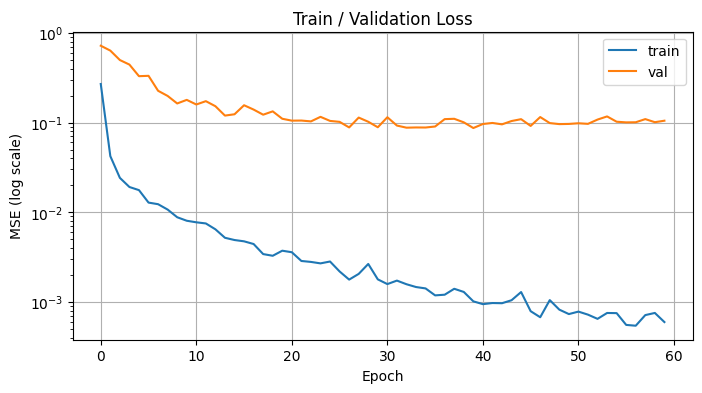

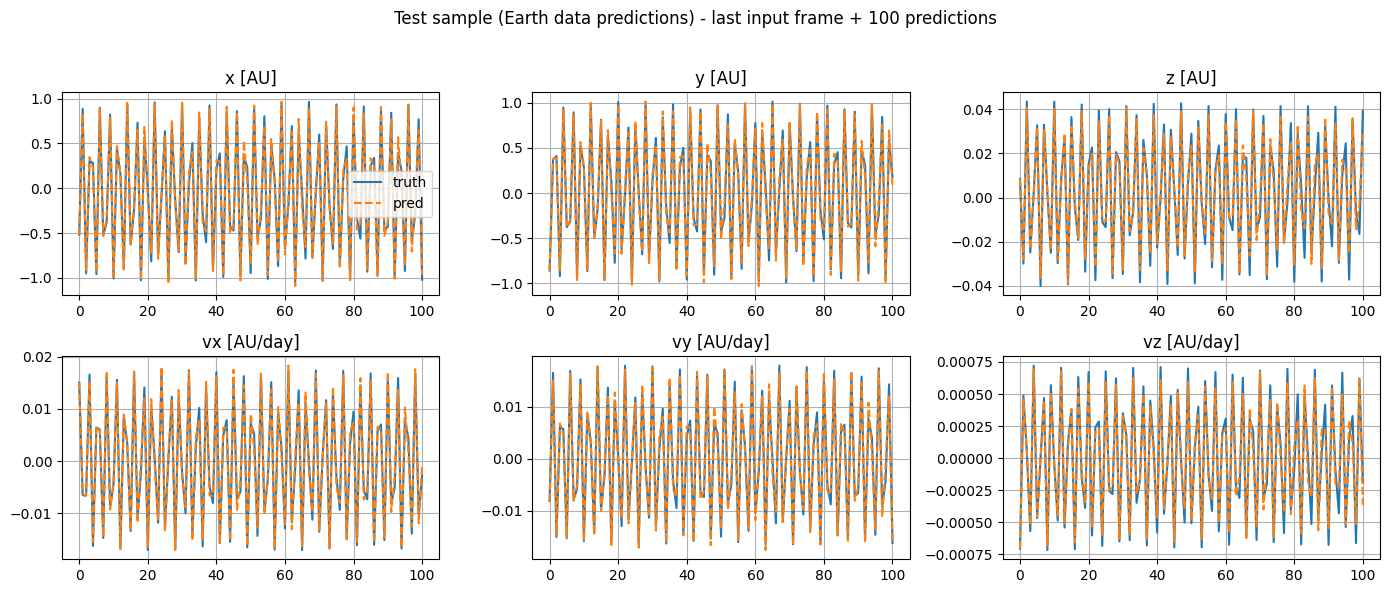

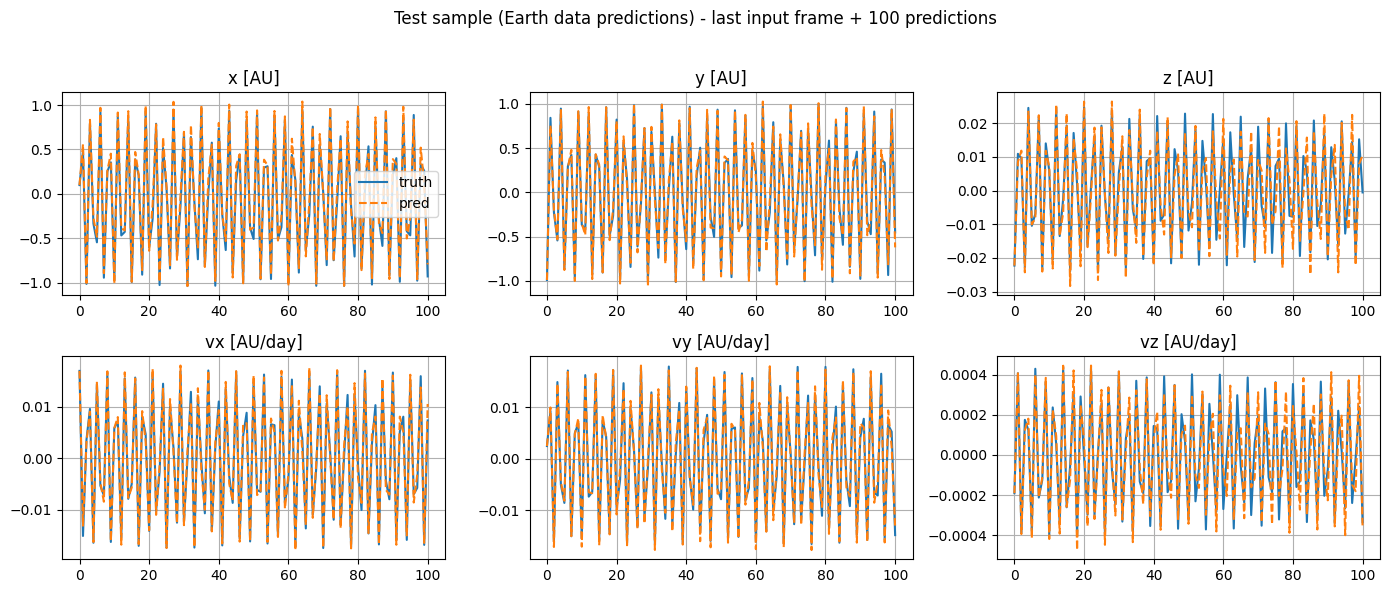

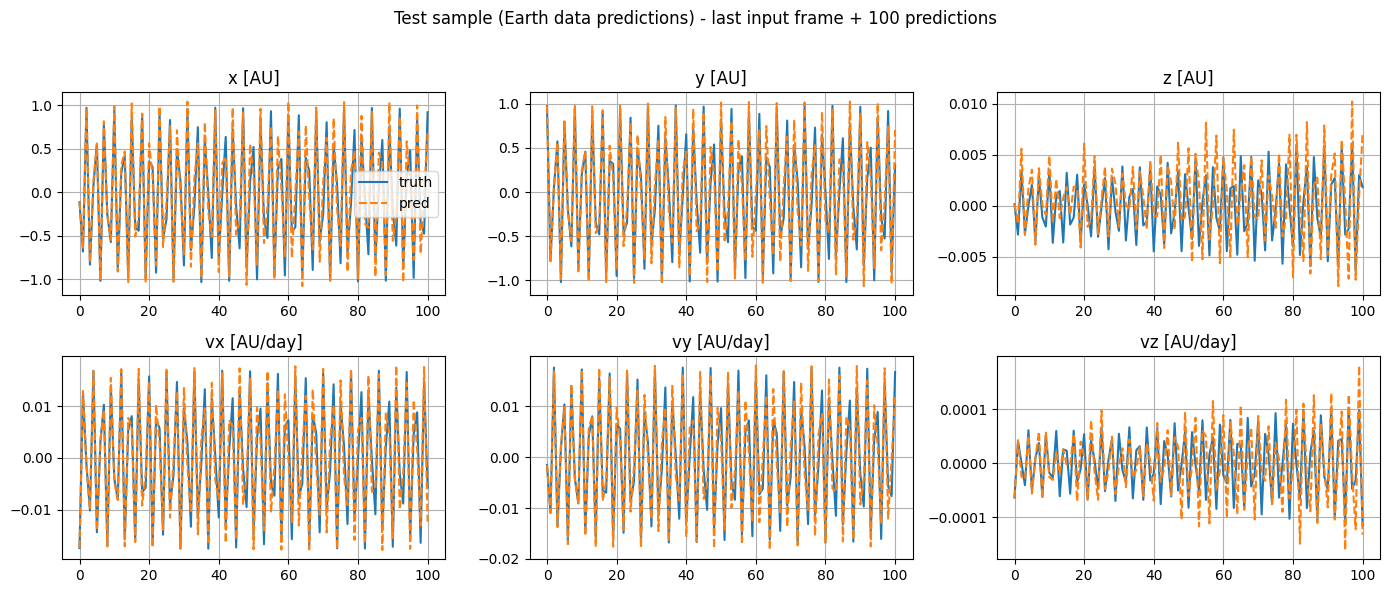

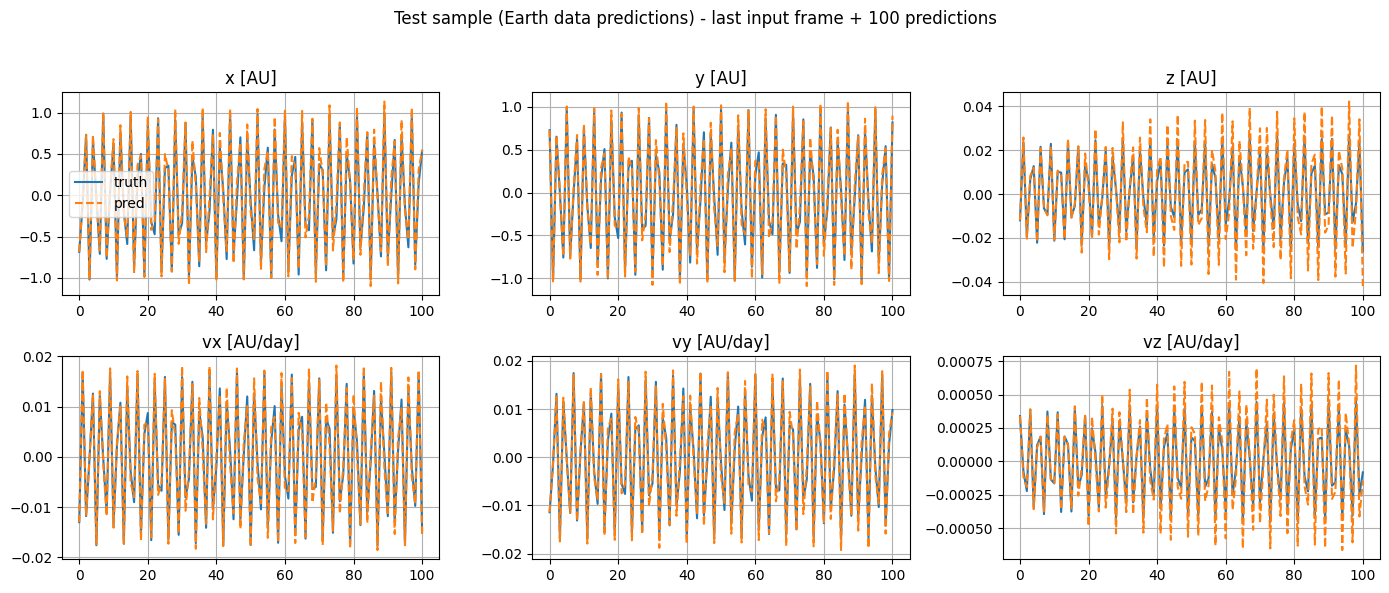

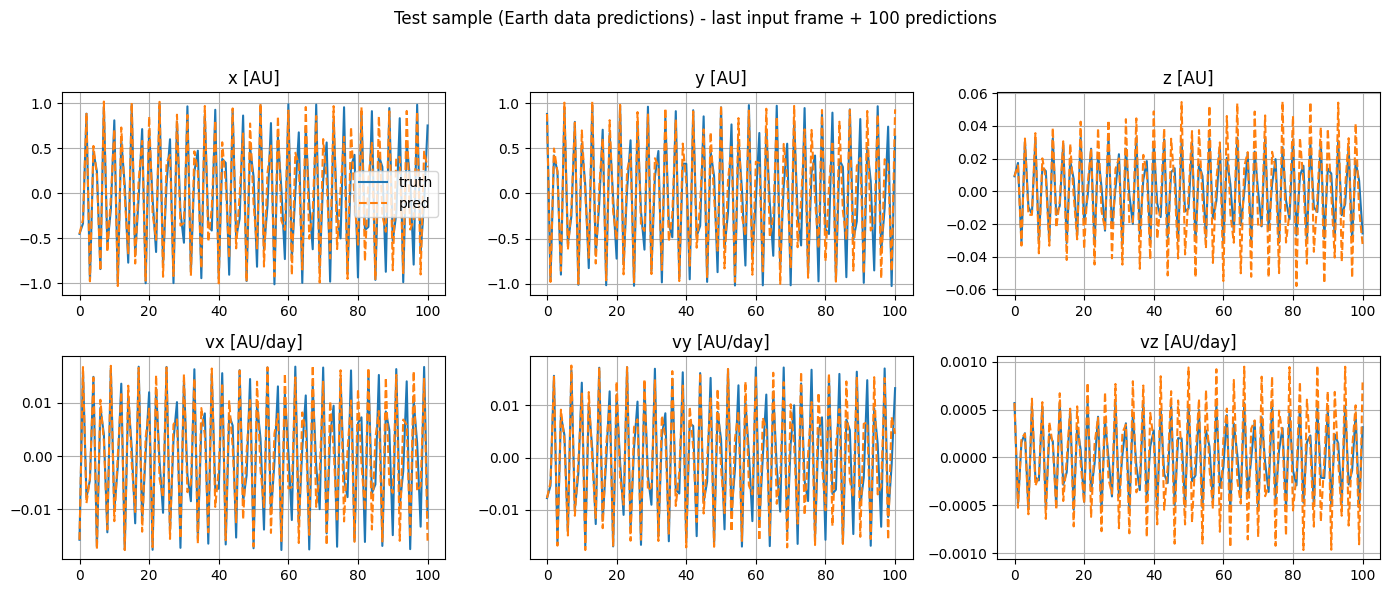

In [9]:
use_all_bodies = True # if True: use all bodies (features=6*num_bodies), if False: use Earth data only

# select feature columns (depending on whethe I want to use the data from all the bodies or only Earth)
if use_all_bodies:
    feature_cols = cols[1:1 + num_bodies*6]
else:
    start = 1 + earth_index*6
    feature_cols = cols[start:start+6]

data = df[feature_cols].values.astype(float)
times = df["t"].values.astype(float)

# build sequences (sliding windows)
X = []
Y = []
for i in range(0, len(data) - seq_in - pred_horizon + 1):
    X.append(data[i:i+seq_in])
    Y.append(data[i+seq_in:i+seq_in+pred_horizon])

X = np.stack(X)
Y = np.stack(Y)

# time-based train/test split
n_samples = X.shape[0]
train_idx = int(n_samples * 0.8)
X_train, X_test = X[:train_idx], X[train_idx:]
Y_train, Y_test = Y[:train_idx], Y[train_idx:]
print("Train / Test samples:", X_train.shape[0], X_test.shape[0])

# scale the features (fit on the training set only)
scaler = StandardScaler()
scaler.fit(np.vstack([X_train.reshape(-1, X_train.shape[-1]), Y_train.reshape(-1, Y_train.shape[-1])]))
def scale_arr(a): return scaler.transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
X_train_s = scale_arr(X_train)
X_test_s = scale_arr(X_test)
Y_train_s = scale_arr(Y_train)
Y_test_s = scale_arr(Y_test)

# creat data loaders for training and test data
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_loader = DataLoader(SeqDataset(X_train_s, Y_train_s), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(SeqDataset(X_test_s, Y_test_s), batch_size=batch_size, shuffle=False, drop_last=False)

# initializze model and loss
n_features = X_train_s.shape[-1]
model = Seq2SeqLSTM(n_features, hidden_size=hidden_size, n_layers=num_layers, pred_horizon=pred_horizon).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
crit = nn.MSELoss()

# Training loop (with the teacher forcing probability)
train_losses = []
val_losses = []
best_val = float('inf')
for ep in range(1, epochs+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        out = model(xb, target_seq=yb, teacher_forcing_prob=teacher_forcing_prob)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation
    model.eval()
    running = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb, target_seq=None, teacher_forcing_prob=0.0)
            running += crit(out, yb).item() * xb.size(0)
    val_loss = running / len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {ep}/{epochs}  train_loss={train_loss:.6e}  val_loss={val_loss:.6e}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_seq2seq_model.pth")

# evaluate on test set and plot predictions
model.load_state_dict(torch.load("best_seq2seq_model.pth", map_location=device))
model.eval()
all_preds, all_truths = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device); yb = yb.to(device)
        out = model(xb, target_seq=None, teacher_forcing_prob=0.0)
        all_preds.append(out.cpu().numpy())
        all_truths.append(yb.cpu().numpy())
all_preds = np.vstack(all_preds)
all_truths = np.vstack(all_truths)

def inv_scale(a): return scaler.inverse_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
mse_per_sample = ((inv_scale(all_preds) - inv_scale(all_truths))**2).mean(axis=(1,2))
print(f"Test MSE: mean={mse_per_sample.mean():.6e}, std={mse_per_sample.std():.6e}")

# plot train/val loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("MSE (log scale)"); plt.legend(); plt.grid(True)
plt.title("Train / Validation Loss")
plt.show()

# choose test examples and ploting Earth data components (x,y,z,vx,vy,vz)
n_plot = min(test_plot_samples, all_preds.shape[0])
idxs = np.linspace(0, all_preds.shape[0]-1, n_plot, dtype=int)
if use_all_bodies and (earth_index < num_bodies):
    s = slice(6*earth_index, 6*earth_index+6)
else:
    s = slice(0, 6)

for k, idx in enumerate(idxs):
    pred = inv_scale(all_preds[idx])
    truth = inv_scale(all_truths[idx])
    last_input = inv_scale(X_test_s[idx][-1:])[0]
    fig, axs = plt.subplots(2,3, figsize=(14,6))
    comps = ['x [AU]','y [AU]','z [AU]','vx [AU/day]','vy [AU/day]','vz [AU/day]']
    for i in range(6):
        ax = axs.flatten()[i]
        y_truth = np.concatenate([last_input[s][i:i+1], truth[:, s][..., i].reshape(-1)])
        y_pred  = np.concatenate([last_input[s][i:i+1], pred[:, s][..., i].reshape(-1)])
        t_full = np.arange(0, 1 + pred_horizon)
        ax.plot(t_full, y_truth, label='truth')
        ax.plot(t_full, y_pred,  label='pred', linestyle='--')
        ax.set_title(comps[i]); ax.grid(True)
        if i==0: ax.legend()
    fig.suptitle(f"Test sample (Earth data predictions) - last input frame + {pred_horizon} predictions")
    plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

# save scaler and meta to not lose them 
with open("scaler_and_meta.pkl", "wb") as f:
    pickle.dump({"scaler": scaler, "feature_cols": feature_cols, "use_all_bodies": use_all_bodies,
                 "seq_in": seq_in, "pred_horizon": pred_horizon}, f)


Train / Test samples: 9172 2294
Epoch 1/60  train_loss=1.962929e-01  val_loss=8.044385e-02
Epoch 2/60  train_loss=2.282080e-03  val_loss=1.215872e-02
Epoch 3/60  train_loss=1.588576e-03  val_loss=1.316703e-02
Epoch 4/60  train_loss=1.482114e-03  val_loss=2.503266e-02
Epoch 5/60  train_loss=1.498608e-03  val_loss=1.420915e-02
Epoch 6/60  train_loss=1.487125e-03  val_loss=1.108446e-02
Epoch 7/60  train_loss=1.448900e-03  val_loss=3.213421e-02
Epoch 8/60  train_loss=1.411450e-03  val_loss=1.767133e-02
Epoch 9/60  train_loss=1.334749e-03  val_loss=6.735371e-03
Epoch 10/60  train_loss=1.273319e-03  val_loss=4.731620e-02
Epoch 11/60  train_loss=1.296053e-03  val_loss=1.786420e-02
Epoch 12/60  train_loss=1.286355e-03  val_loss=1.855243e-02
Epoch 13/60  train_loss=1.332704e-03  val_loss=1.173318e-01
Epoch 14/60  train_loss=1.200296e-03  val_loss=2.026708e-02
Epoch 15/60  train_loss=9.620794e-04  val_loss=5.228888e-03
Epoch 16/60  train_loss=9.154740e-04  val_loss=1.309549e-01
Epoch 17/60  trai

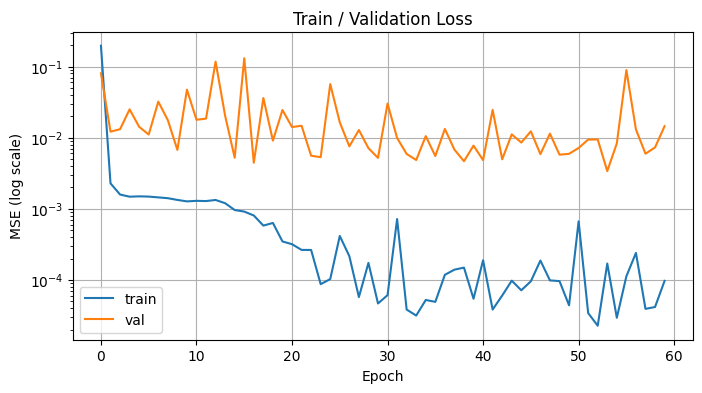

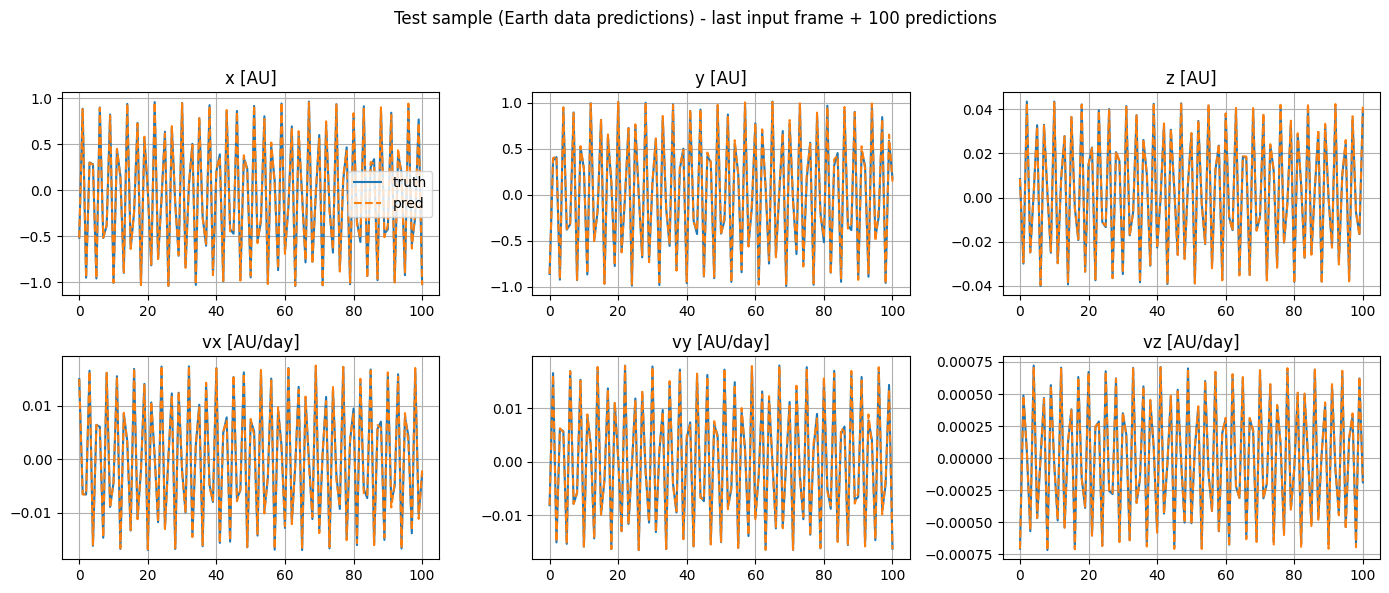

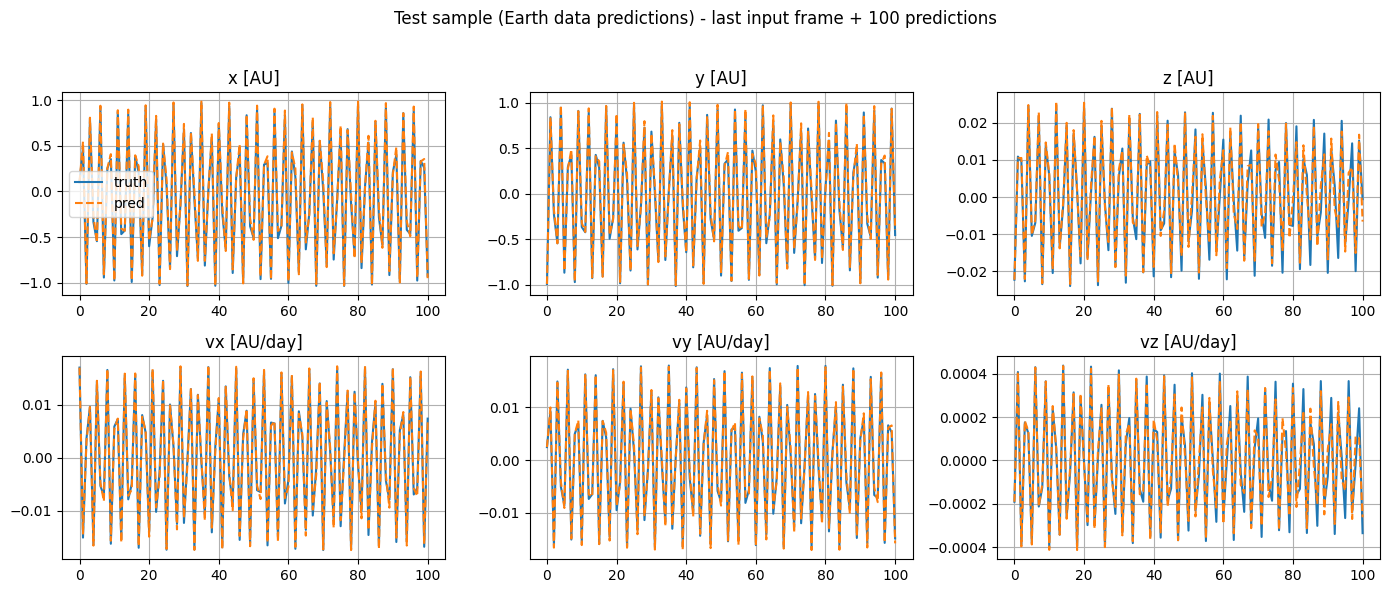

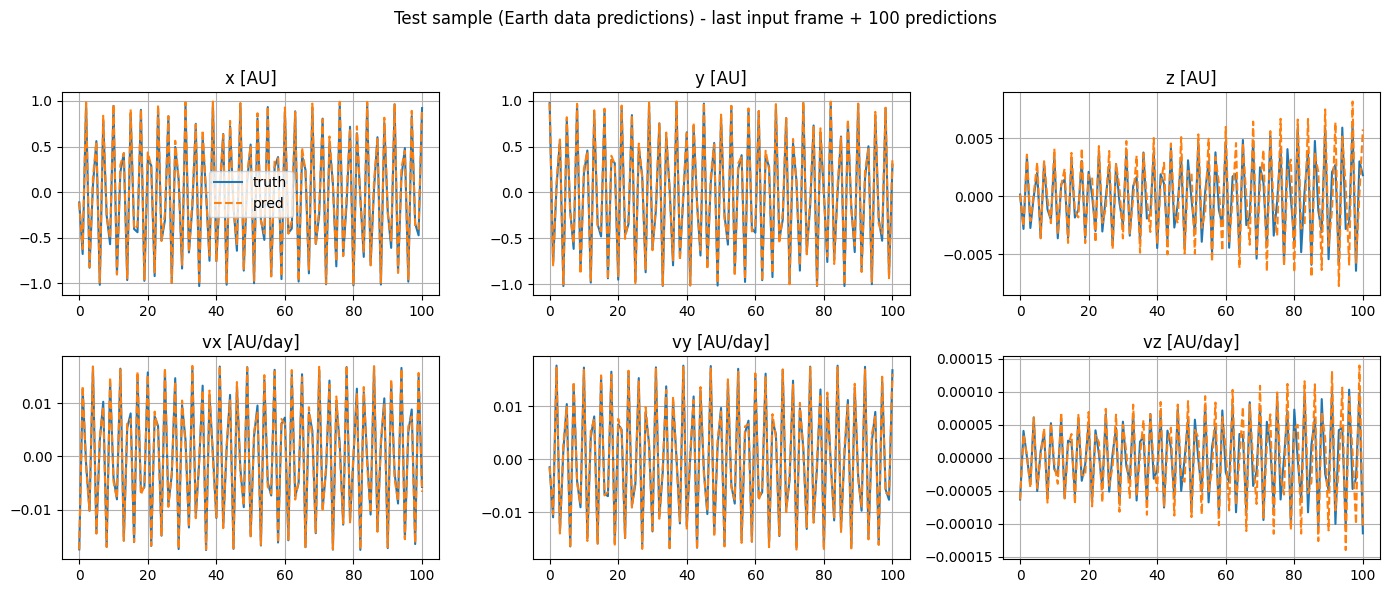

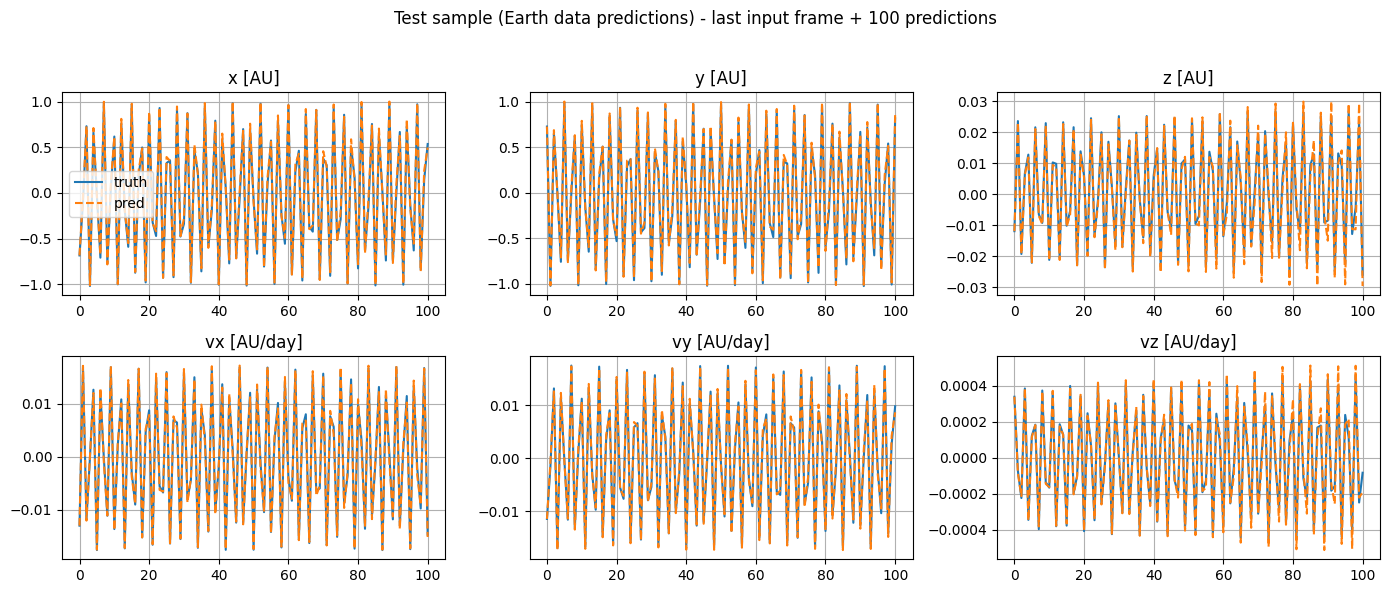

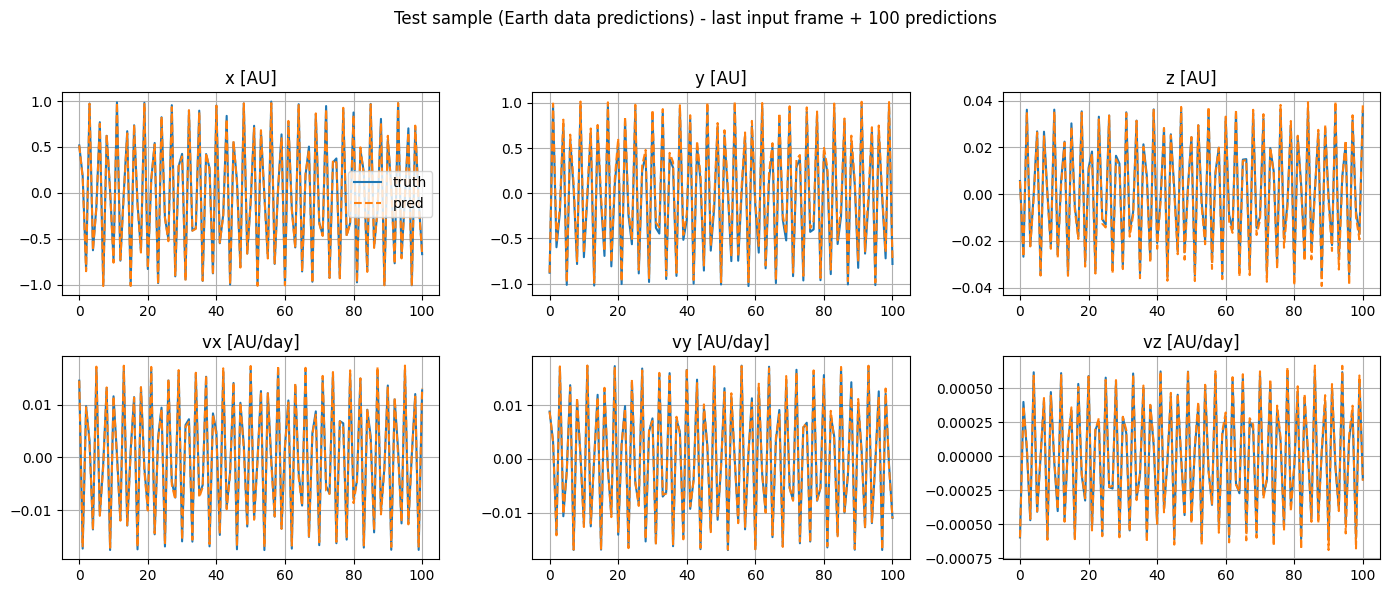

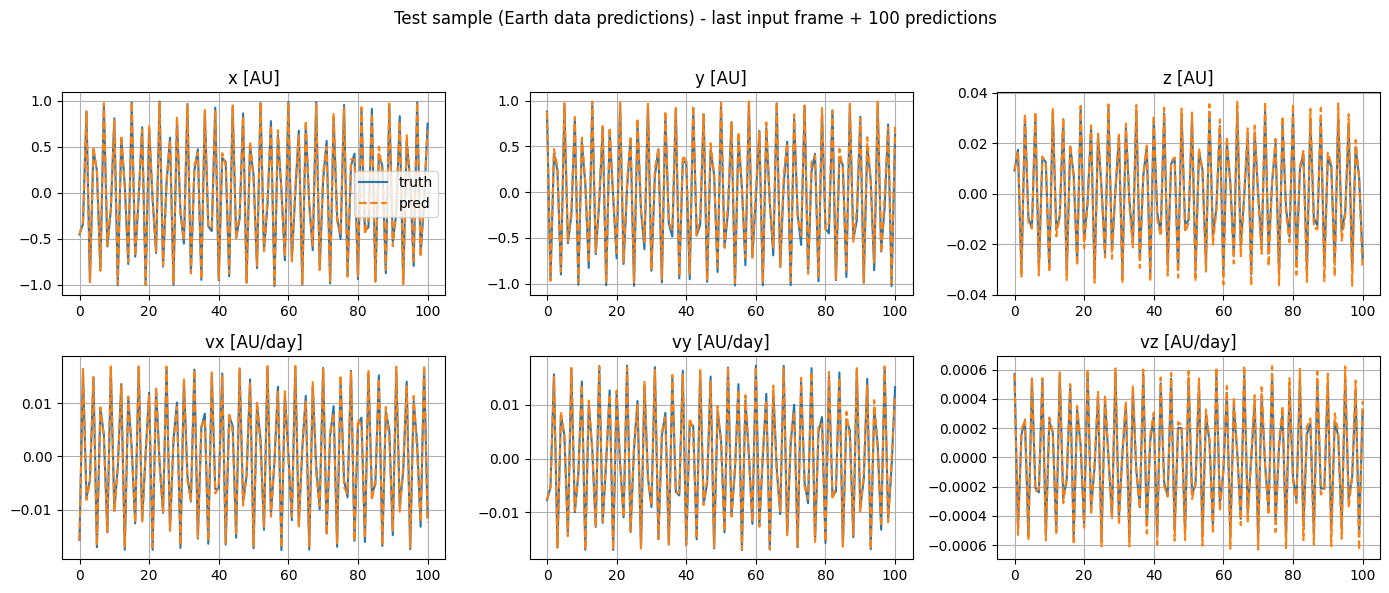

In [10]:
use_all_bodies = False # if True: use all bodies (features=6*num_bodies), if False: use Earth data only

# select feature columns (depending on whethe I want to use the data from all the bodies or only Earth)
if use_all_bodies:
    feature_cols = cols[1:1 + num_bodies*6]
else:
    start = 1 + earth_index*6
    feature_cols = cols[start:start+6]

data = df[feature_cols].values.astype(float)
times = df["t"].values.astype(float)

# build sequences (sliding windows)
X = []
Y = []
for i in range(0, len(data) - seq_in - pred_horizon + 1):
    X.append(data[i:i+seq_in])
    Y.append(data[i+seq_in:i+seq_in+pred_horizon])

X = np.stack(X)
Y = np.stack(Y)

# time-based train/test split
n_samples = X.shape[0]
train_idx = int(n_samples * 0.8)
X_train, X_test = X[:train_idx], X[train_idx:]
Y_train, Y_test = Y[:train_idx], Y[train_idx:]
print("Train / Test samples:", X_train.shape[0], X_test.shape[0])

# scale the features (fit on the training set only)
scaler = StandardScaler()
scaler.fit(np.vstack([X_train.reshape(-1, X_train.shape[-1]), Y_train.reshape(-1, Y_train.shape[-1])]))
def scale_arr(a): return scaler.transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
X_train_s = scale_arr(X_train)
X_test_s = scale_arr(X_test)
Y_train_s = scale_arr(Y_train)
Y_test_s = scale_arr(Y_test)

# creat data loaders for training and test data
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_loader = DataLoader(SeqDataset(X_train_s, Y_train_s), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(SeqDataset(X_test_s, Y_test_s), batch_size=batch_size, shuffle=False, drop_last=False)

# initializze model and loss
n_features = X_train_s.shape[-1]
model = Seq2SeqLSTM(n_features, hidden_size=hidden_size, n_layers=num_layers, pred_horizon=pred_horizon).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
crit = nn.MSELoss()

# Training loop (with the teacher forcing probability)
train_losses = []
val_losses = []
best_val = float('inf')
for ep in range(1, epochs+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        out = model(xb, target_seq=yb, teacher_forcing_prob=teacher_forcing_prob)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation
    model.eval()
    running = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb, target_seq=None, teacher_forcing_prob=0.0)
            running += crit(out, yb).item() * xb.size(0)
    val_loss = running / len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {ep}/{epochs}  train_loss={train_loss:.6e}  val_loss={val_loss:.6e}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_seq2seq_model.pth")

# evaluate on test set and plot predictions
model.load_state_dict(torch.load("best_seq2seq_model.pth", map_location=device))
model.eval()
all_preds, all_truths = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device); yb = yb.to(device)
        out = model(xb, target_seq=None, teacher_forcing_prob=0.0)
        all_preds.append(out.cpu().numpy())
        all_truths.append(yb.cpu().numpy())
all_preds = np.vstack(all_preds)
all_truths = np.vstack(all_truths)

def inv_scale(a): return scaler.inverse_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
mse_per_sample = ((inv_scale(all_preds) - inv_scale(all_truths))**2).mean(axis=(1,2))
print(f"Test MSE: mean={mse_per_sample.mean():.6e}, std={mse_per_sample.std():.6e}")

# plot train/val loss
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("MSE (log scale)"); plt.legend(); plt.grid(True)
plt.title("Train / Validation Loss")
plt.show()

# choose test examples and ploting Earth data components (x,y,z,vx,vy,vz)
n_plot = min(test_plot_samples, all_preds.shape[0])
idxs = np.linspace(0, all_preds.shape[0]-1, n_plot, dtype=int)
if use_all_bodies and (earth_index < num_bodies):
    s = slice(6*earth_index, 6*earth_index+6)
else:
    s = slice(0, 6)

for k, idx in enumerate(idxs):
    pred = inv_scale(all_preds[idx])
    truth = inv_scale(all_truths[idx])
    last_input = inv_scale(X_test_s[idx][-1:])[0]
    fig, axs = plt.subplots(2,3, figsize=(14,6))
    comps = ['x [AU]','y [AU]','z [AU]','vx [AU/day]','vy [AU/day]','vz [AU/day]']
    for i in range(6):
        ax = axs.flatten()[i]
        y_truth = np.concatenate([last_input[s][i:i+1], truth[:, s][..., i].reshape(-1)])
        y_pred  = np.concatenate([last_input[s][i:i+1], pred[:, s][..., i].reshape(-1)])
        t_full = np.arange(0, 1 + pred_horizon)
        ax.plot(t_full, y_truth, label='truth')
        ax.plot(t_full, y_pred,  label='pred', linestyle='--')
        ax.set_title(comps[i]); ax.grid(True)
        if i==0: ax.legend()
    fig.suptitle(f"Test sample (Earth data predictions) - last input frame + {pred_horizon} predictions")
    plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

# save scaler and meta to not lose them 
with open("scaler_and_meta.pkl", "wb") as f:
    pickle.dump({"scaler": scaler, "feature_cols": feature_cols, "use_all_bodies": use_all_bodies,
                 "seq_in": seq_in, "pred_horizon": pred_horizon}, f)
